In [51]:
import os

In [52]:
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from typing import Literal
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

In [53]:
from dotenv import load_dotenv
load_dotenv()

True

In [55]:
llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))

In [56]:
from __future__ import annotations

from typing import Annotated, Sequence, TypedDict, Optional, List
import operator

from langchain_core.messages import BaseMessage


class RecipeAgentState(TypedDict, total=False):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    ingredients: list[str]
    dietary_restrictions: list[str]
    max_cooking_time: int  # minutes
    cuisine_preference: str
    matched_recipes: list[dict]

In [57]:
class UserInput(BaseModel):
    ingredients: List[str] = Field(default_factory=list, description="Ingredients the user has")
    dietary_restrictions: List[str] = Field(
        default_factory=list,
        description='Allowed: "vegetarian", "vegan", "gluten-free"'
    )
    max_cooking_time: Optional[int] = Field(default=None, description="Minutes")
    cuisine_preference: Optional[str] = Field(default=None, description="Cuisine name, if any")


In [58]:
extractor = llm.with_structured_output(UserInput)

In [59]:
EXTRACTION_SYSTEM = """You extract structured cooking preferences from a user message.
Return ONLY valid JSON (no markdown, no explanation) with keys:
{
  "ingredients": [string],
  "dietary_restrictions": [string],   // allowed: "vegetarian","vegan","gluten-free"
  "max_cooking_time": integer|null,   // minutes
  "cuisine_preference": string|null
}

Rules:
- Ingredients: list foods the user says they have (no quantities).
- If user doesn't specify something, use null (or [] for lists).
- Be conservative: don't invent ingredients.
"""

In [60]:
def extract_user_preferences(state: RecipeAgentState) -> RecipeAgentState:
    """Extract ingredients from text."""
    messages = [{"role": "system", "content": EXTRACTION_SYSTEM},] + state["messages"]
    response = extractor.invoke(messages)
    return {
        "ingredients": response.ingredients,
        "dietary_restrictions": response.dietary_restrictions,
        "max_cooking_time": response.max_cooking_time,
        "cuisine_preference": response.cuisine_preference,
    }
    

In [61]:
RECIPES_DB = [
    {"name": "Vegetable Fried Rice",
     "ingredients": ["rice", "vegetables", "soy sauce", "garlic"],
     "dietary": ["vegetarian"], "cuisine": "Asian", "cooking_time": 15},
    {"name": "Veggie Rice Bowl",
     "ingredients": ["rice", "vegetables", "beans", "avocado"],
     "dietary": ["vegan", "gluten-free"], "cuisine": "Fusion", "cooking_time": 18},
    {"name": "Mediterranean Rice Salad",
     "ingredients": ["rice", "cucumber", "olive oil", "lemon"],
     "dietary": ["vegan", "gluten-free"], "cuisine": "Mediterranean", "cooking_time": 20},
    {"name": "Tofu Stir Fry",
     "ingredients": ["tofu", "vegetables", "soy sauce", "ginger"],
     "dietary": ["vegan"], "cuisine": "Asian", "cooking_time": 20},
    {"name": "Egg Fried Rice",
     "ingredients": ["rice", "eggs", "soy sauce", "peas"],
     "dietary": ["vegetarian"], "cuisine": "Asian", "cooking_time": 12},
    {"name": "Greek Salad",
     "ingredients": ["cucumber", "tomato", "feta", "olive oil"],
     "dietary": ["vegetarian", "gluten-free"], "cuisine": "Greek", "cooking_time": 10},
    {"name": "Pasta Primavera",
     "ingredients": ["pasta", "vegetables", "olive oil", "garlic"],
     "dietary": ["vegetarian"], "cuisine": "Italian", "cooking_time": 25},
    {"name": "Chickpea Curry",
     "ingredients": ["chickpeas", "tomato", "onion", "spices"],
     "dietary": ["vegan", "gluten-free"], "cuisine": "Indian", "cooking_time": 30},
    {"name": "Chicken Rice Skillet",
     "ingredients": ["chicken", "rice", "onion", "broth"],
     "dietary": ["none"], "cuisine": "American", "cooking_time": 25},
    {"name": "Lentil Soup",
     "ingredients": ["lentils", "carrot", "celery", "onion"],
     "dietary": ["vegan", "gluten-free"], "cuisine": "Comfort", "cooking_time": 35},
]


In [62]:
def search_recipes(state: RecipeAgentState) -> RecipeAgentState:
    """Search for recipes based on given criteria."""
    ingredients = set(i.lower() for i in state.get("ingredients", []))
    dietary = set(state.get("dietary_restrictions", []))
    max_time = state.get("max_cooking_time", None)
    cuisine_pref = (state.get("cuisine_preference", "") or "").lower()

    matches = []
    for r in RECIPES_DB:
        r_ings = set(x.lower() for x in r["ingredients"])

        if dietary and (not dietary.issubset(set(r["dietary"]))):
            continue
        if max_time is not None and r["cooking_time"] > max_time:
            continue

        overlap = len(ingredients.intersection(r_ings)) if ingredients else 0
        if ingredients and overlap == 0:
            continue

        score = overlap + (2 if cuisine_pref and r["cuisine"].lower() == cuisine_pref else 0)
        matches.append({**r, "score": score})

    return {
        "matched_recipes": matches
    }

In [63]:
from langchain_core.messages import SystemMessage, AIMessage

In [64]:
def rank_recipes(state: RecipeAgentState) -> RecipeAgentState:
    """Rank recipes based on relevance to user preferences."""
    recipes = state.get("matched_recipes", []) or []
    if not recipes:
        return {"matched_recipes": []}

    prompt = (
        "You are a cooking assistant.\n"
        "Rank the following recipes from best to worst for the user.\n\n"
        "User preferences:\n"
        f"- Ingredients: {state.get('ingredients', [])}\n"
        f"- Dietary: {state.get('dietary_restrictions', [])}\n"
        f"- Max time: {state.get('max_cooking_time', None)}\n"
        f"- Cuisine: {state.get('cuisine_preference', None)}\n\n"
        "Recipes:\n"
    )

    for r in recipes:
        prompt += (
            f"- {r['name']} | cuisine={r['cuisine']} | "
            f"time={r['cooking_time']} | score={r['score']}\n"
        )

    prompt += (
        "\nReturn ONLY a comma-separated list of recipe names "
        "ranked from best to worst. Do not add anything else."
    )

    response = llm.invoke([
        SystemMessage(content=prompt)
    ])

    ranked_names = [x.strip() for x in response.content.split(",") if x.strip()]

    # Map back to recipes safely
    name_to_recipe = {r["name"]: r for r in recipes}
    ranked = [name_to_recipe[n] for n in ranked_names if n in name_to_recipe]

    # Fallback: append any missing recipes by original score
    remaining = [r for r in recipes if r["name"] not in ranked_names]
    remaining = sorted(remaining, key=lambda r: r["score"], reverse=True)

    return {"matched_recipes": ranked + remaining}

In [65]:
from langchain_core.messages import SystemMessage, AIMessage

def generate_recommendation(state: RecipeAgentState) -> RecipeAgentState:
    recipes = state.get("matched_recipes", []) or []
    ingredients = state.get("ingredients", []) or []

    # Edge cases
    if not ingredients:
        return {"messages": [AIMessage(content="Tell me what ingredients you have so I can recommend recipes.")]}
    if not recipes:
        return {"messages": [AIMessage(content="I couldn’t find a matching recipe. Want to relax constraints or add more ingredients?")]}

    prompt = f"""
You are a friendly cooking assistant.

User preferences:
- Ingredients: {state.get("ingredients", [])}
- Dietary restrictions: {state.get("dietary_restrictions", [])}
- Max cooking time: {state.get("max_cooking_time", None)}
- Cuisine preference: {state.get("cuisine_preference", None)}

Candidate recipes (use ONLY these, do not invent new recipes):
{recipes}

Task:
1) Pick the BEST 3 recipes from the candidates for this user.
2) Write the final response EXACTLY in this format:

Based on your ingredients and preferences, here are 3 recipes:
1. <name> (<time> min) - <cuisine>
2. <name> (<time> min) - <cuisine>
3. <name> (<time> min) - <cuisine>


No extra text. No explanations. Only the formatted response.
"""

    response = llm.invoke([SystemMessage(content=prompt)])
    return {"messages": [AIMessage(content=response.content)]}


In [66]:
def build_recipe_graph():
    g = StateGraph(RecipeAgentState)

    g.add_node("extract_user_preferences", extract_user_preferences)
    g.add_node("search_recipes", search_recipes)
    g.add_node("rank_recipes", rank_recipes)
    g.add_node("generate_recommendation", generate_recommendation)

    g.set_entry_point("extract_user_preferences")
    g.add_edge("extract_user_preferences", "search_recipes")
    g.add_edge("search_recipes", "rank_recipes")
    g.add_edge("rank_recipes", "generate_recommendation")
    g.add_edge("generate_recommendation", END)

    return g.compile()

In [67]:
graph=build_recipe_graph()

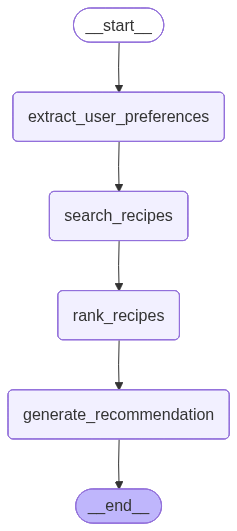

In [68]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [69]:
from langchain_core.messages import HumanMessage

In [70]:
for s in graph.stream({"messages": [("user", "I have rice, vegetables, beans, avocado and i have 20 minutes time. can you suggest me a recipe")]}, subgraphs=True):
    print(s)
    print("----")

((), {'extract_user_preferences': {'ingredients': ['rice', 'vegetables', 'beans', 'avocado'], 'dietary_restrictions': [], 'max_cooking_time': 20, 'cuisine_preference': None}})
----
((), {'search_recipes': {'matched_recipes': [{'name': 'Vegetable Fried Rice', 'ingredients': ['rice', 'vegetables', 'soy sauce', 'garlic'], 'dietary': ['vegetarian'], 'cuisine': 'Asian', 'cooking_time': 15, 'score': 2}, {'name': 'Veggie Rice Bowl', 'ingredients': ['rice', 'vegetables', 'beans', 'avocado'], 'dietary': ['vegan', 'gluten-free'], 'cuisine': 'Fusion', 'cooking_time': 18, 'score': 4}, {'name': 'Mediterranean Rice Salad', 'ingredients': ['rice', 'cucumber', 'olive oil', 'lemon'], 'dietary': ['vegan', 'gluten-free'], 'cuisine': 'Mediterranean', 'cooking_time': 20, 'score': 1}, {'name': 'Tofu Stir Fry', 'ingredients': ['tofu', 'vegetables', 'soy sauce', 'ginger'], 'dietary': ['vegan'], 'cuisine': 'Asian', 'cooking_time': 20, 'score': 1}, {'name': 'Egg Fried Rice', 'ingredients': ['rice', 'eggs', 'soy